<a href="https://colab.research.google.com/github/Deepak-Mewada/NeuralDecoder/blob/main/BrainDecoder/Basics/Finger_flexion_cropped_decoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mne
!pip install braindecode

In [ ]:
!pip install moabb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 563.8/563.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 77.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.2/119.2 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 13.5 MB/s eta 0:00:00
  Created wheel for pyriemann: filename=pyriemann-0.5-py2.py3-none-any.whl size=107752 sha256=5ce08f4d18f30825b179a94b4f54c2f3532aa381f5599bc1989e3ebbd6d2c0db
  Stored in directory: /root/.cache/pip/wheels/84/86/79/622e9c1dc933dc088e287ebfaac5aa9bdc6a38a9db193ce1f1
Successfully built pyriemann
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7
  Attempting uninst

In [ ]:
import copy

import numpy as np
import sklearn
from mne import set_log_level

from braindecode.datasets import BCICompetitionIVDataset4

subject_id = 1
dataset = BCICompetitionIVDataset4(subject_ids=[subject_id])

MNE_DATA is not already configured. It will be set to default location in the home directory - /root/mne_data
All datasets will be downloaded to this location, if anything is already downloaded, please move manually to this location


SHA256 hash of downloaded file: 04c237ab33f25eb11c93d4cea69693823693d16ef145d4a034a77ddae6238ebb
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


In [ ]:
dataset = dataset.split('session')
train_set = dataset['train']
test_set = dataset['test']

In [ ]:
from braindecode.preprocessing import (Preprocessor,
                                       exponential_moving_standardize,
                                       preprocess)

low_cut_hz = 1.
high_cut_hz = 200.

factor_new = 1e-3
init_block_size = 1000

In [ ]:
valid_set = preprocess(copy.deepcopy(train_set),
                       [Preprocessor('crop', tmin=24, tmax=30)], n_jobs=-1)
preprocess(train_set, [Preprocessor('crop', tmin=0, tmax=24)], n_jobs=-1)
preprocess(test_set, [Preprocessor('crop', tmin=0, tmax=24)], n_jobs=-1)

In [ ]:
preprocessors = [

    Preprocessor('pick_types', ecog=True, misc=True),
    Preprocessor(lambda x: x / 1e6, picks='ecog'),
    Preprocessor('filter', l_freq=low_cut_hz, h_freq=high_cut_hz),
    Preprocessor(exponential_moving_standardize,
                 factor_new=factor_new, init_block_size=init_block_size, picks='ecog')
]

preprocess(train_set, preprocessors)
preprocess(valid_set, preprocessors)
preprocess(test_set, preprocessors)


sfreq = train_set.datasets[0].raw.info['sfreq']
assert all([ds.raw.info['sfreq'] == sfreq for ds in train_set.datasets])

target_sfreq = train_set.datasets[0].raw.info['temp']['target_sfreq']

/usr/local/lib/python3.10/dist-packages/braindecode/preprocessing/preprocess.py:55: UserWarning: Preprocessing choices with lambda functions cannot be saved.
  warn('Preprocessing choices with lambda functions cannot be saved.')


In [ ]:
input_window_samples = 1000

In [ ]:
import torch

from braindecode.models import ShallowFBCSPNet
from braindecode.util import set_random_seeds

cuda = torch.cuda.is_available()
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True

seed = 20200220
set_random_seeds(seed=seed, cuda=cuda)

n_classes = 1

n_chans = train_set[0][0].shape[0] - 5

model = ShallowFBCSPNet(
    n_chans,
    n_classes,
    final_conv_length=2,
    add_log_softmax=False,
)


if cuda:
    model.cuda()

from braindecode.models import get_output_shape, to_dense_prediction_model

to_dense_prediction_model(model)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function to_dense_prediction_model is deprecated; will be removed in version 1.0. Use EEGModuleMixin.to_dense_prediction_model method directly on the model object.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
n_preds_per_input = get_output_shape(model, n_chans, input_window_samples)[2]

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function get_output_shape is deprecated; will be removed in version 1.0. Use EEGModuleMixin.get_output_shape method directly on the model object.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
from braindecode.preprocessing import create_fixed_length_windows

train_set = create_fixed_length_windows(
    train_set,
    start_offset_samples=0,
    stop_offset_samples=None,
    window_size_samples=input_window_samples,
    window_stride_samples=n_preds_per_input,
    drop_last_window=False,
    targets_from='channels',
    last_target_only=False,
    preload=False
)

valid_set = create_fixed_length_windows(
    valid_set,
    start_offset_samples=0,
    stop_offset_samples=None,
    window_size_samples=input_window_samples,
    window_stride_samples=n_preds_per_input,
    drop_last_window=False,
    targets_from='channels',
    last_target_only=False,
    preload=False
)

test_set = create_fixed_length_windows(
    test_set,
    start_offset_samples=0,
    stop_offset_samples=None,
    window_size_samples=input_window_samples,
    window_stride_samples=n_preds_per_input,
    drop_last_window=False,
    targets_from='channels',
    last_target_only=False,
    preload=False
)

In [ ]:
train_set.target_transform = lambda x: x[0: 1]
valid_set.target_transform = lambda x: x[0: 1]
test_set.target_transform = lambda x: x[0: 1]

In [ ]:
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split

from braindecode import EEGRegressor
from braindecode.training import CroppedTimeSeriesEpochScoring, TimeSeriesLoss


lr = 0.0625 * 0.01
weight_decay = 0
batch_size = 27
n_epochs = 8

regressor = EEGRegressor(
    model,
    cropped=True,
    aggregate_predictions=False,
    criterion=TimeSeriesLoss,
    criterion__loss_function=torch.nn.functional.mse_loss,
    optimizer=torch.optim.AdamW,
    train_split=predefined_split(valid_set),
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    iterator_train__shuffle=True,
    batch_size=batch_size,
    callbacks=[
        ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
        ('r2_train', CroppedTimeSeriesEpochScoring(sklearn.metrics.r2_score,
                                                   lower_is_better=False,
                                                   on_train=True,
                                                   name='r2_train')
         ),
        ('r2_valid', CroppedTimeSeriesEpochScoring(sklearn.metrics.r2_score,
                                                   lower_is_better=False,
                                                   on_train=False,
                                                   name='r2_valid')
         )
    ],
    device=device,
)
set_log_level(verbose='WARNING')

In [ ]:
regressor.fit(train_set, y=None, epochs=n_epochs)

  epoch    r2_train    r2_valid    train_loss    valid_loss      lr     dur
-------  ----------  ----------  ------------  ------------  ------  ------
      1    -16.9029     -8.3094        2.5378       20.7336  0.0006  2.0510
      2    -13.7521     -7.1261        1.9596       18.0756  0.0006  1.9390
      3    -12.7752     -6.7418        1.6787       17.1907  0.0005  1.7333
      4    -11.7953     -6.3924        1.5638       16.4442  0.0004  1.1758
      5    -11.2697     -6.1851        1.4237       16.0121  0.0002  1.1651
      6    -10.5722     -5.9213        1.3549       15.4457  0.0001  1.1637
      7     -9.8216     -5.6189        1.3132       14.7817  0.0000  1.1778
      8     -9.0633     -5.3054        1.3316       14.0900  0.0000  1.1656


In [ ]:
def pad_and_select_predictions(preds, y):
    preds = np.pad(preds,
                   ((0, 0), (0, 0), (y.shape[2] - preds.shape[2], 0)),
                   'constant',
                   constant_values=0)

    mask = ~np.isnan(y[0, 0, :])
    preds = np.squeeze(preds[..., mask], 0)
    y = np.squeeze(y[..., mask], 0)
    return y.T, preds.T


preds_train, y_train = regressor.predict_trials(train_set, return_targets=True)
preds_train, y_train = pad_and_select_predictions(preds_train, y_train)

preds_valid, y_valid = regressor.predict_trials(valid_set, return_targets=True)
preds_valid, y_valid = pad_and_select_predictions(preds_valid, y_valid)

preds_test, y_test = regressor.predict_trials(test_set, return_targets=True)
preds_test, y_test = pad_and_select_predictions(preds_test, y_test)

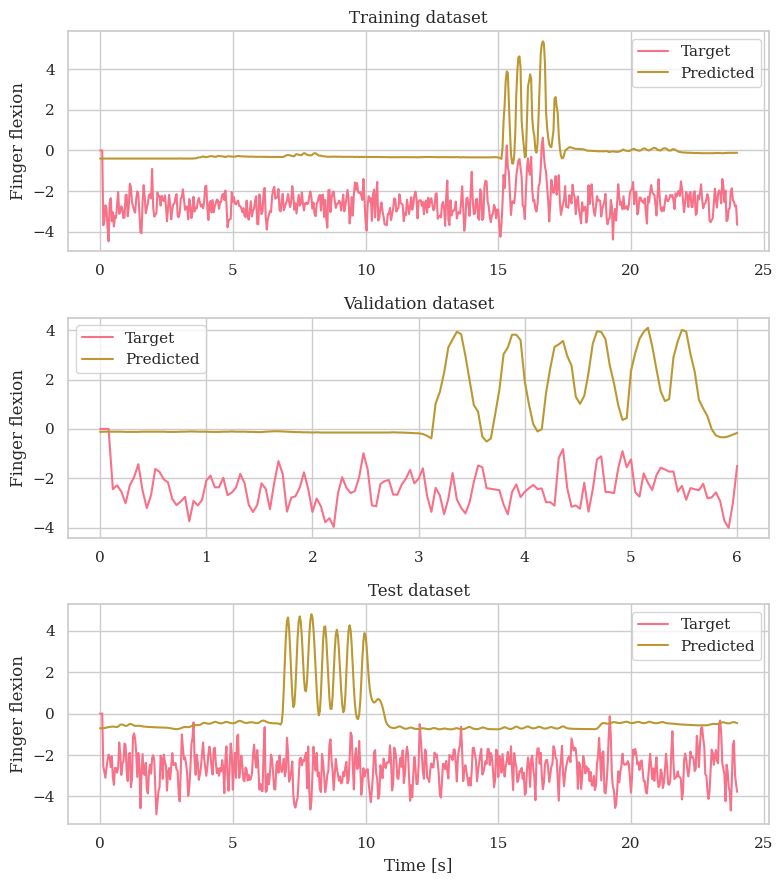

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

fig, axes = plt.subplots(3, 1, figsize=(8, 9))

axes[0].set_title('Training dataset')
axes[0].plot(np.arange(y_train.shape[0]) / target_sfreq, y_train[:, 0], label='Target')
axes[0].plot(np.arange(preds_train.shape[0]) / target_sfreq, preds_train[:, 0],
             label='Predicted')
axes[0].set_ylabel('Finger flexion')
axes[0].legend()

axes[1].set_title('Validation dataset')
axes[1].plot(np.arange(y_valid.shape[0]) / target_sfreq, y_valid[:, 0], label='Target')
axes[1].plot(np.arange(preds_valid.shape[0]) / target_sfreq, preds_valid[:, 0],
             label='Predicted')
axes[1].set_ylabel('Finger flexion')
axes[1].legend()

axes[2].set_title('Test dataset')
axes[2].plot(np.arange(y_test.shape[0]) / target_sfreq, y_test[:, 0], label='Target')
axes[2].plot(np.arange(preds_test.shape[0]) / target_sfreq, preds_test[:, 0], label='Predicted')
axes[2].set_xlabel('Time [s]')
axes[2].set_ylabel('Finger flexion')
axes[2].legend()
plt.tight_layout()

In [ ]:
corr_coeffs = []
for dim in range(y_test.shape[1]):
    corr_coeffs.append(
        np.corrcoef(preds_test[:, dim], y_test[:, dim])[0, 1]
    )
print('Correlation coefficient for each dimension: ', np.round(corr_coeffs, 2))

Correlation coefficient for each dimension:  [-0.1]


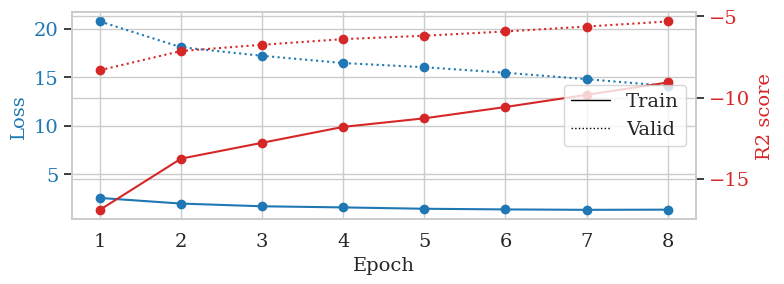

In [ ]:
results_columns = ['train_loss', 'valid_loss', 'r2_train', 'r2_valid']
df = pd.DataFrame(regressor.history[:, results_columns], columns=results_columns,
                  index=regressor.history[:, 'epoch'])

fig, ax1 = plt.subplots(figsize=(8, 3))
df.loc[:, ['train_loss', 'valid_loss']].plot(
    ax=ax1, style=['-', ':'], marker='o', color='tab:blue', legend=False, fontsize=14)

ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)
ax1.set_ylabel("Loss", color='tab:blue', fontsize=14)

ax2 = ax1.twinx()

df.loc[:, ['r2_train', 'r2_valid']].plot(
    ax=ax2, style=['-', ':'], marker='o', color='tab:red', legend=False)
ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=14)
ax2.set_ylabel("R2 score", color='tab:red', fontsize=14)
ax1.set_xlabel("Epoch", fontsize=14)


handles = []
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle='-',
                      label='Train'))
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle=':',
                      label='Valid'))
plt.legend(handles, [h.get_label() for h in handles], fontsize=14, loc='center right')
plt.tight_layout()